# Load Data

In [1]:
import numpy as np
import csv
import io
from os import mkdir
import json
import datetime
import pandas as pd 
from datetime import timedelta
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import preprocessing
import lightgbm as lgb
import matplotlib.pyplot as plt
from math import radians, sin, asin, sqrt, atan2
from util.plot_funcs import *
from random import uniform
from imblearn.over_sampling import RandomOverSampler
%load_ext autoreload
%autoreload 2
import warnings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

/Users/shiwang/Desktop/Personal/test_API/env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_queries = pd.read_csv('./data_set_phase1/train_queries.csv')
train_plans = pd.read_csv('./data_set_phase1/train_plans.csv')
train_clicks = pd.read_csv('./data_set_phase1/train_clicks.csv')
test_queries = pd.read_csv('./data_set_phase1/test_queries.csv')
test_plans = pd.read_csv('./data_set_phase1/test_plans.csv')
profiles = pd.read_csv('./data_set_phase1/profiles.csv')
weather = json.load(open('./data_set_phase1/weather.json'))

In [3]:
train_clicks.head(3)

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2


In [4]:
profiles.head(3)

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
train_queries.head(3)

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"


In [6]:
train_plans.head(3)

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."


In [7]:
with open('./data_set_phase1/weather.json', 'r') as f:
    weather_dict = json.load(f)

# Pre-processing

In [23]:
def pre_process_queries(X):
    X['pid'] = X['pid'].fillna(0)
    X['req_time'] = pd.to_datetime(X['req_time'])
    X['dow'] = X['req_time'].apply(lambda x: x.weekday())
    X['hr'] = X['req_time'].apply(lambda x: x.hour)
    X['min'] = X['req_time'].apply(lambda x: x.minute)
    X['O_lon'] = X['o'].apply(lambda x: float(x.split(',')[0]))
    X['O_lat'] = X['o'].apply(lambda x: float(x.split(',')[1]))
    X['D_lon'] = X['d'].apply(lambda x: float(x.split(',')[0]))
    X['D_lat'] = X['d'].apply(lambda x: float(x.split(',')[1]))
    X['date'] =  X['req_time'].apply(lambda x:x.date())
    
    del X['o']
    del X['d']
    del X['req_time']
    
    return X

In [24]:
%%time
train_queries = pre_process_queries(train_queries)
test_queries = pre_process_queries(test_queries)

CPU times: user 7.07 s, sys: 138 ms, total: 7.21 s
Wall time: 7.21 s


In [25]:
def pre_process_plan(X):
    try:
        X['plans'] = X['plans'].apply(lambda x: eval(x))
    except:
        pass
    
    outputs = []
    for _, row in X.iterrows():
        sid = row['sid']
        rank = 0
        for plan in row['plans']:
            outputs.append([sid, 
                            plan['distance'], 
                            plan['price'], 
                            plan['eta'], 
                            plan['transport_mode'],
                            rank])
            rank += 1
    
    output = pd.DataFrame(outputs, columns = ['sid','distance', 'price', 'eta','transport_mode', 'rank'])  
    output['price'] = output['price'].replace('',-1)
    output['distance'] = output['distance'].replace('',-1)
    output['eta'] = output['eta'].replace('',-1)
    return output

In [26]:
%%time
train_plans_ = pre_process_plan(train_plans)
test_plans_  = pre_process_plan(test_plans)

CPU times: user 1min 28s, sys: 913 ms, total: 1min 29s
Wall time: 1min 29s


In [27]:
train_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)
test_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)

In [28]:
%%time
profiles['profile'] = profiles.apply(lambda row: [x + 1 for x in range(66) if row['p'+str(x)] == 1], axis = 1)
profiles = profiles.append({'pid': 0 , 'profile' : []} , ignore_index=True).fillna(0)

CPU times: user 29 s, sys: 44.1 ms, total: 29 s
Wall time: 29 s


In [29]:
train_clicks = train_clicks[['sid','click_mode']]
train_clicks['label'] = 1

# Merge 3 tables

In [30]:
# train = train_plans_.merge(train_queries, on ='sid')\
#             .merge(profiles, on = 'pid')\
#             .merge(train_clicks[['sid']], on = 'sid')\ 
#             .merge(train_clicks, left_on = ['sid', 'transport_mode'], 
#                    right_on = ['sid', 'click_mode'], how = 'left')
# del train['click_mode']
# train['label'] = train['label'].fillna(0)

In [31]:
train = train_plans_.merge(train_queries, on ='sid')\
            .merge(profiles, on = 'pid')\
            .merge(train_clicks, left_on = ['sid', 'transport_mode'], 
                   right_on = ['sid', 'click_mode'], how = 'left')
del train['click_mode']
train['label'] = train['label'].fillna(0)

In [32]:
test = test_plans_.merge(test_queries, on ='sid').merge(profiles, on = 'pid')

**Deal with queries without plans**

In [33]:
len(train_queries), len(train_plans),len(train_clicks),

(500000, 491054, 453336)

In [34]:
l1 = set(train_queries['sid'])
l2 = set(train_plans['sid'])
l3 = set(train_clicks['sid'])

In [35]:
len(l1), len(l2), len(l3)

(500000, 491054, 453336)

In [36]:
plan_no_click_sid = [x for x in l1 if (x not in l3) and (x in l2)]

In [37]:
len(plan_no_click_sid)

37718

*Assume click_mode for these queries to be first one*

In [38]:
train.loc[(train['sid'].isin(plan_no_click_sid)) & (train['rank'] == 0), 'label'] = 1

In [39]:
sum(train.groupby('sid')['label'].agg(max) == 1)

491054

# Feature Engineering

In [53]:
#train = train[train['date'] >  datetime.date(2018, 10, 7)]

In [54]:
stations = pd.read_table('./data_set_phase1/station.txt', sep = ',', header = None)
stations.columns = ['station', 'lat', 'lon']

In [55]:
def add_dis_near_stations(df):
    dis = []
    for lon, lat in zip(df['lon'], df['lat']):
        dis.append( min( abs(stations['lon'] - lon) + abs(stations['lat'] - lat) ) )
    df['dis'] = dis
    return df

In [56]:
O = pd.concat([train[['O_lon', 'O_lat']], test[['O_lon', 'O_lat']] ], axis = 0).drop_duplicates()
D = pd.concat([train[['D_lon', 'D_lat']], test[['D_lon', 'D_lat']] ], axis = 0).drop_duplicates()
O.columns = ['lon','lat']
D.columns = ['lon','lat']
OD = pd.concat([O,D], axis = 0).drop_duplicates()
len(OD)

6121

In [57]:
%%time
OD = add_dis_near_stations(OD)
train = train.merge(OD.rename(columns = {'dis':'O_dis'}), left_on=['O_lon','O_lat'], right_on = ['lon', 'lat'])
train = train.merge(OD.rename(columns = {'dis':'D_dis'}), left_on=['D_lon','D_lat'], right_on = ['lon', 'lat'])
test = test.merge(OD.rename(columns = {'dis':'O_dis'}), left_on=['O_lon','O_lat'], right_on = ['lon', 'lat'])
test = test.merge(OD.rename(columns = {'dis':'D_dis'}), left_on=['D_lon','D_lat'], right_on = ['lon', 'lat'])

CPU times: user 11.9 s, sys: 3.2 s, total: 15.1 s
Wall time: 15.1 s


In [58]:
for col in ['lon_x', 'lat_x', 'lon_y', 'lat_y']:
    del train[col]
    del test[col]

In [59]:
def add_num_plans(df):
    num_plans = df.groupby(['sid'], as_index = False)['rank'].agg({'num_plans':lambda x: max(x) + 1})
    df = df.merge(num_plans, how = 'left', on = 'sid')
    return df

In [60]:
%%time
train = add_num_plans(train)
test = add_num_plans(test)

CPU times: user 10.8 s, sys: 3.34 s, total: 14.1 s
Wall time: 14.1 s


In [61]:
train = train[(train['num_plans'] > 1)]

In [62]:
def lat_lon_dis(train, test):
    l1,l2 = len(train),len(test)
    dis_cols = []
    for col in ['O_lat', 'O_lon', 'D_lat', 'D_lon']:
        temp = pd.concat([train[[col]],test[[col]]], axis=0).rank(method='dense')
        temp = list(temp[col])
        temp = pd.qcut(temp, 5, labels=False, duplicates='drop')
        train[col+'_dis'] = temp[:l1]
        test[col+'_dis']  = temp[l1:]
        dis_cols.append(col+'_dis')
        
    train['od'] = train[dis_cols].values.tolist()
    test['od']  = test[dis_cols].values.tolist()
    train['od'] = train['od'].apply(lambda x: ','.join([str(xx) for xx in x]))
    test['od']   = test['od'].apply(lambda x: ','.join([str(xx) for xx in x]))
                                    
    train['o'] = train[['O_lat', 'O_lon']].values.tolist()
    test['o']  = test[['O_lat', 'O_lon']].values.tolist()
    train['o'] = train['o'].apply(lambda x: ','.join([str(xx) for xx in x]))
    test['o']   = test['o'].apply(lambda x: ','.join([str(xx) for xx in x]))
                                    
    train['d'] = train[['D_lat', 'D_lon']].values.tolist()
    test['d']  = test[['D_lat', 'D_lon']].values.tolist()
    train['d'] = train['d'].apply(lambda x: ','.join([str(xx) for xx in x]))
    test['d']   = test['d'].apply(lambda x: ','.join([str(xx) for xx in x]))
    return train, test

In [63]:
%%time
train, test = lat_lon_dis(train, test)

CPU times: user 16.7 s, sys: 1.21 s, total: 17.9 s
Wall time: 17.9 s


In [64]:
def cal_manhattan_distance(O_lon, O_lat, D_lon, D_lat):
    dlat = O_lat - D_lat
    a = sin(dlat / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371
    lat_d = c * r

    dlon = O_lat - D_lat
    a = sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371
    lon_d = c * r

    return lat_d + lon_d

In [65]:
def add_manhattan_distance(df):
    df['man_distance'] = df.apply(lambda row: cal_manhattan_distance(
        row['O_lon'], row['O_lat'], row['D_lon'], row['D_lat']), axis = 1)
    return df

In [66]:
%%time
train = add_manhattan_distance(train)
test = add_manhattan_distance(test)

CPU times: user 1min 18s, sys: 3.03 s, total: 1min 21s
Wall time: 1min 21s


In [67]:
def col_dis(train, test, cols):
    l1,l2 = len(train),len(test)
    for col in cols:
        temp = pd.concat([train[[col]],test[[col]]], axis=0).rank(method='dense')
        temp = list(temp[col])
        temp = pd.qcut(temp, 10, labels=False, duplicates='drop')
        train[col+'_dis'] = temp[:l1]
        test[col+'_dis']  = temp[l1:]
    return train, test

In [68]:
%%time
train, test = col_dis(train, test, ['man_distance'])

CPU times: user 1.39 s, sys: 807 ms, total: 2.2 s
Wall time: 2.2 s


In [69]:
def add_other_modes(df):
    temp = df.groupby('sid', as_index=False)['transport_mode']\
            .agg({'mode_list':lambda x: ','.join(sorted(x.astype(str), key = lambda x:int(x)))})
    df = df.merge(temp, on = 'sid')
    return df

In [70]:
%%time
train = add_other_modes(train)
test = add_other_modes(test)

CPU times: user 1min 24s, sys: 2.94 s, total: 1min 27s
Wall time: 1min 27s


In [71]:
def add_direction(df):
    df['lon_diff'] = df['O_lon'] - df['D_lon']
    df['lat_diff'] = df['O_lat'] - df['D_lat']
    return df

In [72]:
%%time
train = add_direction(train)
test = add_direction(test)

CPU times: user 57.7 ms, sys: 8.52 ms, total: 66.2 ms
Wall time: 22.8 ms


In [73]:
def add_max_min(df):
    cols = ['eta','distance','price']
    temp_columns = ['sid'] + [x + '_' + y for x in cols for y in ['min', 'max', 'mean', 'std']]
    temp = df.groupby('sid', as_index = False).agg({'eta':[min, max, np.mean, np.std], 
                                                    'distance':[min, max, np.mean, np.std], 
                                                    'price':[min, max, np.mean, np.std]})
    temp.columns = temp.columns.droplevel()
    temp.columns = temp_columns
    
    df = df.merge(temp, on = 'sid')
    for col in cols:
        for t in ['min', 'max']:
            df[col + '_is_' + t] = df[col] == df[col + '_' + t]
            df[col + '_ratio_' + t] = df[col] / (df[col + '_' + t] + 0.001)            
    return df

In [74]:
%%time
train = add_max_min(train)
test = add_max_min(test)

CPU times: user 8.01 s, sys: 4.64 s, total: 12.6 s
Wall time: 12.3 s


In [75]:
def add_divide(df):
    df['eta_per_distance'] = df['eta'] / (df['distance'] + 0.001)
    df['price_per_distance'] = df['price'] / (df['distance'] + 0.001)
    df['price_per_eta'] = df['price'] / (df['eta'] + 0.001)
    
    temp = df.groupby('transport_mode', as_index = 'False').agg({'eta_per_distance':np.median,
                                                                 'price_per_distance':np.median,
                                                                 'price_per_eta':np.median}).reset_index()
    
    temp.columns  = ['transport_mode', 'eta_dis_avg','price_dis_avg','price_eta_avg']
    
    df = df.merge(temp, on = 'transport_mode')
    df['eta_per_distance_abs'] = df['eta_per_distance'] / df['eta_dis_avg']
    df['price_per_distance_abs'] = df['price_per_distance'] / df['price_dis_avg']
    df['price_per_eta_abs'] = df['price_per_eta'] / df['price_eta_avg']
                           
    del df['eta_dis_avg']                                                     
    del df['price_dis_avg']
    del df['price_eta_avg']
    return df

In [76]:
%%time
train = add_divide(train)
test = add_divide(test)

CPU times: user 21.9 s, sys: 11.4 s, total: 33.3 s
Wall time: 33 s


In [77]:
train['price_NA'] = train['price'] == -1
test['price_NA'] = test['price'] == -1

In [78]:
def add_time(df):
    df['is_night'] = df['hr'].isin([22,23,0,1,2,3,4,5])
    df['is_weekend'] = df['dow'].isin([5,6])
    return df

In [79]:
%%time
train = add_time(train)
test = add_time(test)

CPU times: user 34.4 ms, sys: 1.78 ms, total: 36.2 ms
Wall time: 35.2 ms


In [80]:
def remove_profile(train, test):
    remove_profiles = []
    for i in range(0, 66):
        try:
            if (train['p' + str(i)].mean() < 0.1) or \
               (test['p' + str(i)].mean() < 0.1) or \
               (abs(train['p' + str(i)].mean() -  test['p' + str(i)].mean()) > 0.20):
                    remove_profiles.append('p' + str(i)) 
        except:
            pass
    return remove_profiles

In [81]:
%%time
remove_profiles = remove_profile(train, test)

CPU times: user 706 ms, sys: 101 ms, total: 807 ms
Wall time: 806 ms


In [82]:
def add_dummies(df):
    dummies = pd.get_dummies(df['transport_mode'], prefix='mode')
    return pd.concat([df, dummies], axis = 1)

In [83]:
%%time
train = add_dummies(train)
test = add_dummies(test)

CPU times: user 3.23 s, sys: 1.83 s, total: 5.06 s
Wall time: 5.06 s


In [84]:
def add_dow_hr(df):
    df['dow_hr'] = df['dow'].astype(str) + '_' + df['hr'].astype(str)
    return df

In [85]:
%%time
train = add_dow_hr(train)
test = add_dow_hr(test)

CPU times: user 2.35 s, sys: 145 ms, total: 2.49 s
Wall time: 2.49 s


In [86]:
def add_cross_stats(train, test):
    for col in ['od',
                'hr',
                'dow',
                'rank',
                'dow_hr',#05/24
                'mode_list',
                'is_night', 
                'is_weekend', 
                'num_plans',
                'price_is_max', 
                'price_is_min',
                'eta_is_max', 
                'eta_is_min',
                'distance_is_max', 
                'distance_is_min']:
        colname = 'mode_'+ col + '_clicks'
        if colname not in train:
            temp = train.groupby( [col, 'transport_mode'], as_index = False)\
                    .agg({'label':np.mean}).rename(columns = {'label':colname})
            train = train.merge(temp, on = ['transport_mode', col], how = 'left')
            test  = test.merge(temp, on = ['transport_mode', col], how = 'left')
            train[colname] = train[colname].fillna(0)
            test[colname]  = test[colname].fillna(0)
            print(col)
    return train, test

In [87]:
%%time
train, test = add_cross_stats(train, test)

od
hr
dow
rank
dow_hr
mode_list
is_night
is_weekend
num_plans
price_is_max
price_is_min
eta_is_max
eta_is_min
distance_is_max
distance_is_min
CPU times: user 3min 19s, sys: 2min 20s, total: 5min 39s
Wall time: 5min 39s


**Add week number**

In [88]:
train['week_no'] = 0
test['week_no'] = 0
for i in range(10):
    train.loc[(train['date'] >=  datetime.date(2018, 10, 1) + timedelta(days=7 * i)) \
            & (train['date'] <=  datetime.date(2018, 10, 7) + timedelta(days=7 * i)) \
              , 'week_no'] = i 
    test.loc[(test['date'] >=  datetime.date(2018, 10, 1) + timedelta(days=7 * i)) \
           & (test['date'] <=  datetime.date(2018, 10, 7) + timedelta(days=7 * i)) \
              , 'week_no'] = i 

**Add mode list as categorical vairable**

In [89]:
temp = pd.DataFrame(train['mode_list'].value_counts()).reset_index()
temp.columns = ['mode_list', 'count']
temp['mode_list_high'] = temp['mode_list']
temp = temp[temp['count'] >= 10000]
del temp['count']
temp.head(1)

,mode_list,mode_list_high
0,"1,3,4,5,6","1,3,4,5,6"


In [91]:
%%time
train = train.merge(temp, on = 'mode_list', how = 'left')
test  = test.merge(temp, on = 'mode_list', how = 'left')
train['mode_list_high'] = train['mode_list_high'].fillna('other')
test['mode_list_high']  = test['mode_list_high'].fillna('other')
le = preprocessing.LabelEncoder()
le.fit(train['mode_list_high'])
train['mode_list_high'] = le.transform(train['mode_list_high'])
test['mode_list_high']  = le.transform(test['mode_list_high'])

CPU times: user 17.2 s, sys: 12.2 s, total: 29.3 s
Wall time: 29.3 s


**Add hr + 30 minute**

In [283]:
def minute_to_30(x):
    if x<30:
        return 1
    else:
        return 2

In [284]:
%%time
train['min_30'] = train['min'].apply(minute_to_30)
test['min_30'] = test['min'].apply(minute_to_30)
train['hr_minute'] = 2 * train['hr'] + train['min_30']
test['hr_minute']  = 2 * test['hr']  + test['min_30']
del train['min_30'] 
del test['min_30']

CPU times: user 773 ms, sys: 57.9 ms, total: 831 ms
Wall time: 793 ms


**Add divide 10 for cross stats**

In [78]:
def divide_10(x):
    for i in range(10):
        if x >= 0.1 * i and x <= 0.1 * (i+1):
            return i
    return 0

In [3]:
cross_cols_dis = []
cross_cols = []
def add_cross_stats_divide_10(train, test):
    for col in ['od',
                'hr',
                'dow',
                'rank',
                'dow_hr',#05/24
                'mode_list',
                'is_night', 
                'is_weekend', 
                'num_plans',
                'price_is_max', 
                'price_is_min',
                'eta_is_max', 
                'eta_is_min',
                'distance_is_max', 
                'distance_is_min']:
        col1 = 'mode_'+ col + '_clicks'
        col2 = 'mode_'+ col + '_clicks_dis'
        train[col2] = train[col1].apply(divide_10)
        test[col2]  = test[col1].apply(divide_10)
        cross_cols.append(col1)
        cross_cols_dis.append(col2)
    return train, test

In [4]:
%%time
train, test =  add_cross_stats_divide_10(train, test)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 16.9 µs


**Add last week clicks**

In [208]:
start = min(train['date'])
train['day'] = (train['date'] - start).apply(lambda x: x.days)
test['day'] = (test['date'] - start).apply(lambda x: x.days)

In [209]:
cols = ['day','hr','transport_mode']

In [210]:
temp = train.groupby(cols , as_index = False)\
                    .agg({'label':np.mean}).rename(columns = {'label':'day_hr_mode_percent'})
temp['day'] = temp['day'] + 7

In [211]:
try:
    del train['day_hr_mode_percent']
    del test['day_hr_mode_percent']
except:
    pass

In [212]:
train = train.merge(temp, on = cols, how = 'left')
test = test.merge(temp, on = cols, how = 'left')
train['day_hr_mode_percent'] = train['day_hr_mode_percent'].fillna(0)
test['day_hr_mode_percent'] = test['day_hr_mode_percent'].fillna(0)

In [213]:
len(train.columns)

166

# Save intermediate data to pickle

In [38]:
%%time
data = {'train': train, 'test':test, 
        'all_test_sid':set(test_queries['sid']), 
        'remove_profiles':remove_profiles}
with open('./processed_data/data.pickle', 'wb') as handle:
    pickle.dump(data, handle)

CPU times: user 5.26 s, sys: 2.49 s, total: 7.75 s
Wall time: 8.18 s


In [447]:
%%time
with open('./processed_data/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

train = data['train']
test = data['test']
all_test_sid = data['all_test_sid']
remove_profiles = data['remove_profiles']

CPU times: user 2.23 s, sys: 3.26 s, total: 5.49 s
Wall time: 5.52 s


# Baseline LGB model

In [448]:
print(len(train))
#train = train[~train['sid'].isin(plan_no_click_sid)]
print(len(train))

2015306
2015306


## Train/Validation Split

In [449]:
train_ = train.copy()
test_ = test.copy()

In [450]:
exclude_columns = ['sid',
                   'pid',
                   'week_no',
                   'profile',
                   'label',
                   'weight',
                   'mode_list',
                   'date',
                   'o',
                   'd',
                   'od',
                   'O_lat_dis',
                   'O_lon_dis',
                   'D_lat_dis',
                   'D_lon_dis',
                   'mode_o_clicks', 
                   'mode_d_clicks',
                   'transport_mode',
                   'dow_hr',
                   'mode_dow_hr_clicks',
                   'mode_list_high',
                   'min',
                   'hr_minute',    
                   'day',
                   'day_hr_mode_percent'
                   
#                     'price_ratio_max',
#                     'eta_min',
#                     'eta_max',
#                     'eta_mean',
#                     'eta_std',
#                     'distance_min',
#                     'distance_max',
#                     'distance_mean',
#                     'distance_std',
#                     'price_min',
#                     'price_max',
#                     'price_mean',
#                     'price_std',
#                     'eta_is_min',
#                     'eta_is_max',
#                     'distance_is_min',
#                     'distance_is_max',
#                     'price_is_min',
#                     'price_is_max'
                   
                  ] 
features = [x for x in train_.columns if x not in exclude_columns and \
                                         x not in remove_profiles and \
                                         x not in cross_cols_dis]

In [451]:
len(features)

94

In [452]:
sid_train = list(set(train_[train_['date'] >= datetime.date(2018, 10, 7)]['sid']))
sid_eval  = list(set(train_[train_['date'] >= datetime.date(2018, 11, 24)]['sid']))

In [453]:
len(sid_train)

388473

In [454]:
import random
random.seed(1)
#sid_train = random.sample(sid_train,220000)

In [115]:
sid_train = []
for mode in range(1,12):
    sid_train = sid_train + \
    list(train_[(train_['label']==1)  & (train_['transport_mode'] == mode)]['sid'].sample(10000, replace = True).values)

In [455]:
T = train_[train_['sid'].isin(sid_train)]
V = train_[train_['sid'].isin(sid_eval)]

In [456]:
X_train = T
X_eval  = V
y_train = T['label']
y_eval  = V['label']

## Model Training

### Find best sample weights

In [457]:
temp = pd.DataFrame(train_[(train_['label'] == 1)]['transport_mode'].value_counts()).reset_index().sort_values(by = 'index')
temp.columns = ['transport_mode', 'weight']
temp['weight'] = np.sqrt(1 / temp['weight'] * 10000)
base_weights = temp
display(base_weights)

,transport_mode,weight
2,1,0.378216
0,2,0.271006
5,3,0.640460
7,4,0.891969
4,5,0.460825
8,6,0.918475
1,7,0.359882
10,8,2.320567
3,9,0.452382
6,10,0.819727


In [458]:
def weighted_f1(preds, data):
    if GLOBAL[0] % 100 == 0 and data.reference is not None:
        df = X_eval
        df['pred_prob'] = preds
        output = pd.DataFrame(df.groupby('sid').apply(get_best_mode_dt).reset_index())
        output.columns = ['sid', 'recommend_mode']
        eval_true = df[df['label'] == 1][['sid','transport_mode']]
        eval_true.columns = ['sid','true']
        output.columns = ['sid', 'pred']
        eval_sum = eval_true.merge(output, on = 'sid')
        weight_f1 = f1_score(eval_sum['true'], eval_sum['pred'], average = 'weighted')
    else:
        weight_f1 = -1
    GLOBAL[0] = GLOBAL[0] + 1
    return 'weighed-f1', weight_f1, False

In [459]:
def add_weight(train_, adjusts):
    if 'weight' in train_.columns:
        del train_['weight']
    
    weights = base_weights.copy()
    for idx, adjust in zip(range(1,12), adjusts):
        weights.loc[weights['transport_mode'] == idx, 'weight'] = \
        weights.loc[weights['transport_mode'] == idx, 'weight'] * adjust
        
    weights['label'] = 1
    train_ = train_.merge(weights, on = ['transport_mode','label'], how = 'left')
    train_['weight'] = train_['weight'].fillna(1)

    T = train_[train_['sid'].isin(sid_train)]
    V = train_[train_['sid'].isin(sid_eval)]

    X_train = T
    X_eval  = V
    y_train = T['label']
    y_eval  = V['label']
    
    return X_train, X_eval, y_train, y_eval

In [460]:
def train_lgb_with_weights(idx, adjusts, num_rounds = 1000, feval = None, verbose = 200):
    X_train, X_eval, y_train, y_eval = add_weight(train_, adjusts)
    lgb_train = lgb.Dataset(X_train[features], y_train, 
                            categorical_feature = ['hr','dow'],
                            weight = X_train['weight'])

    lgb_evals = lgb.Dataset(X_eval[features], y_eval, 
                                categorical_feature = ['hr','dow'], 
                                reference = lgb_train)    
    print(adjusts)    
    gbm_all = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round = num_rounds,
                    valid_sets =[ lgb_train,lgb_evals],
                    valid_names = ['train','valid'],
                    feval = feval,
                    #early_stopping_rounds = 300,
                    verbose_eval = verbose 
                   ) 
    
    results[idx] = {}
    results[idx]['model'] = gbm_all
    results[idx]['adjusts'] = adjusts
    if feval is not None:
        results[idx]['f1'] = gbm_all.best_score['valid']['weighed-f1']

In [12]:
results = {}
global_idx = [0]

In [64]:
adjusts_sets = [     
            [1, 1, 3, 2, 1, 1.5, 2, 1, 3, 1.5, 1],
               ]

In [ ]:
# %%time
# already_tested = [v['adjusts'] for k ,v in results.items()]
# for adjusts in adjusts_sets:
#     idx = global_idx[0]
#     global_idx[0] = global_idx[0] + 1
#     GLOBAL = [1]
#     train_lgb_with_weights(idx, adjusts,num_rounds = 100, feval=weighted_f1, verbose = 100)

In [65]:
results = {}

### Train model

In [66]:
%%time
GLOBAL = [1]
train_lgb_with_weights(1000, 
                      [1, 1, 3, 2.0, 1, 1.5, 2, 1, 3, 1.5, 1], 
                       num_rounds = 3600, feval = None, verbose = 500) #3600

[1, 1, 3, 2.0, 1, 1.5, 2, 1, 3, 1.5, 1]
CPU times: user 5min 29s, sys: 18.6 s, total: 5min 47s
Wall time: 59.3 s


In [461]:
%%time
#0.65740662 # 0.768070431718125
GLOBAL = [1]
train_lgb_with_weights(max(results.keys()) + 1, 
                      [1, 1, 3, 2.0, 1, 1.5, 2, 1, 3, 1.5, 1], 
                       num_rounds = 3300, feval = None, verbose = 500) 

[1, 1, 3, 2.0, 1, 1.5, 2, 1, 3, 1.5, 1]
[500]	train's binary_logloss: 0.28648	valid's binary_logloss: 0.282242
[1000]	train's binary_logloss: 0.281578	valid's binary_logloss: 0.278748
[1500]	train's binary_logloss: 0.277417	valid's binary_logloss: 0.27577
[2000]	train's binary_logloss: 0.273638	valid's binary_logloss: 0.273085
[2500]	train's binary_logloss: 0.270244	valid's binary_logloss: 0.270663
[3000]	train's binary_logloss: 0.266934	valid's binary_logloss: 0.268369
CPU times: user 1h 10min 36s, sys: 1min 20s, total: 1h 11min 56s
Wall time: 7min 8s


In [85]:
gbm_all = results[max(results.keys())]['model']

In [156]:
feature_importance = sorted([(x,y) for x, y in zip(gbm_all.feature_name(), gbm_all.feature_importance())],
                            key = lambda x: x[1], reverse=True)
top_features = [x for x, y in feature_importance][:50]

In [461]:
X_train, X_eval, y_train, y_eval = add_weight(train_, [1, 1, 3, 2.0, 1, 1.5, 2, 1, 3, 1.5, 1])

In [518]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 31,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'bagging_seed': 0,
 'bagging_freq': 1,
 'verbose': 1,
 'seed': 42,
 'reg_alpha':7.5,
 'reg_lambda':2}

In [519]:
lgb_train = lgb.Dataset(X_train[features], y_train, 
                        categorical_feature = ['hr','dow'],
                        weight = X_train['weight'])

lgb_evals = lgb.Dataset(X_eval[features], y_eval, 
                            categorical_feature = ['hr','dow'], 
                            reference = lgb_train)  

In [520]:
gbm_all = lgb.train(
                params,
                lgb_train,
                num_boost_round =3600,
                valid_sets =[ lgb_train,lgb_evals],
                valid_names = ['train','valid'],
                verbose_eval = 500 
               ) 

[500]	train's binary_logloss: 0.286774	valid's binary_logloss: 0.281614
[1000]	train's binary_logloss: 0.281189	valid's binary_logloss: 0.277794
[1500]	train's binary_logloss: 0.27642	valid's binary_logloss: 0.274528
[2000]	train's binary_logloss: 0.272109	valid's binary_logloss: 0.271699
[2500]	train's binary_logloss: 0.268011	valid's binary_logloss: 0.268952
[3000]	train's binary_logloss: 0.264186	valid's binary_logloss: 0.26641
[3500]	train's binary_logloss: 0.260552	valid's binary_logloss: 0.263883


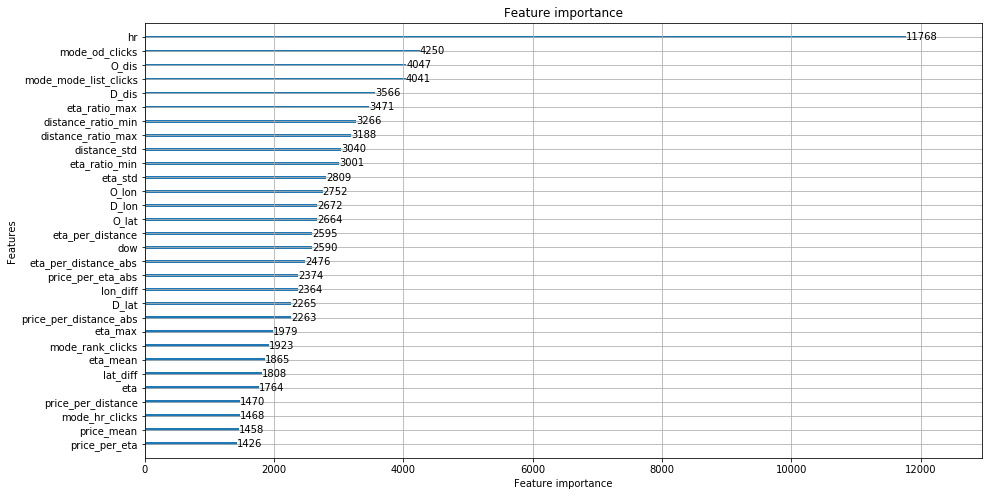

In [521]:
lgb.plot_importance(gbm_all, figsize=(15,8), max_num_features = 30)

## Apply to validation set

**Generate predictions**

In [522]:
def get_best_mode_dt(gp):
    result = [(x, y) for x, y in zip(gp['transport_mode'], gp['pred_prob'])]
    result.sort(key = lambda x: x[1], reverse = True)
    return result[0][0]

In [523]:
def get_predictions_lgb(df, gbm, features):
    pred = gbm.predict(df[features])
    df['pred_prob'] = pred
    output = pd.DataFrame(df.groupby('sid').apply(get_best_mode_dt)).reset_index()
    output.columns = ['sid', 'recommend_mode']
    return df, output 

In [524]:
X_eval, output = get_predictions_lgb(X_eval, gbm_all, features)

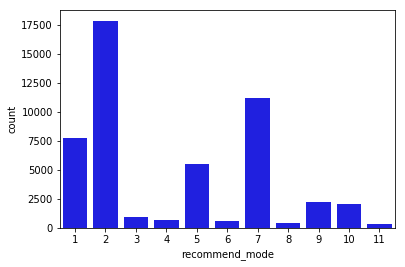

In [525]:
sns.countplot(output['recommend_mode'], color = 'blue') 

In [526]:
eval_true = X_eval[X_eval['label'] == 1][['sid','transport_mode']]
eval_true.columns = ['sid','true']
output.columns = ['sid', 'pred']
eval_sum = eval_true.merge(output, on = 'sid')

In [527]:
weight_f1 = f1_score(eval_sum['true'], eval_sum['pred'], average = 'weighted')

In [528]:
weight_f1

0.7710704279953497

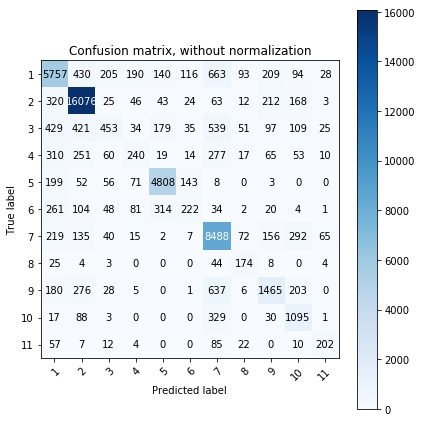

In [529]:
plot_confusion_matrix_(eval_sum['true'], eval_sum['pred'], classes=list(range(1,12)))

## Apply to test set

In [530]:
%%time
test_, output = get_predictions_lgb(test_, gbm_all, features)

CPU times: user 2min 19s, sys: 1.11 s, total: 2min 20s
Wall time: 21.4 s


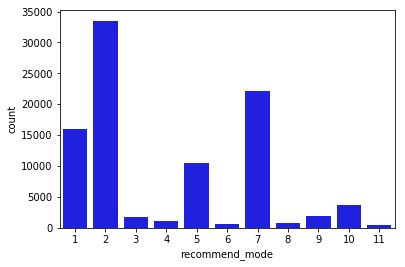

In [531]:
sns.countplot(output['recommend_mode'], color = 'blue')

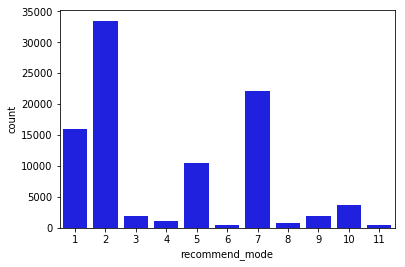

In [473]:
sns.countplot(output['recommend_mode'], color = 'blue') # 0.65740662

**Result Adjustment 1**

In [282]:
output = pd.read_csv('./submission/2019-05-28 21:17:09.989885/submission.csv') 
output['sid'] = output['sid'].astype(int)
output['recommend_mode'] = output['recommend_mode'].astype(int)

In [1297]:
len(output)

94358

In [532]:
ll_cols = ['O_lon','O_lat','D_lon','D_lat','mode_list']

In [533]:
x1 = train[train['label'] == 1].groupby(ll_cols)['sid'].agg({'tot_count':len}).reset_index()
x2 = train[train['label'] == 1].groupby(ll_cols + ['transport_mode'])['sid'].agg({'mode_count':len}).reset_index()\
                                    .merge(x1, on = ll_cols).sort_values(by = ll_cols, ascending = False)
x2['percent'] = x2['mode_count'] / x2['tot_count']

In [534]:
x = x2[(x2['tot_count']>=10) & (x2['percent'] >= 1)]

In [535]:
tmp_test = test.merge(output, on = 'sid')
a1 = tmp_test[tmp_test['transport_mode'] == tmp_test['recommend_mode']].groupby(ll_cols)['sid'].agg({'test_tot_count':len}).reset_index()
a2 = tmp_test[tmp_test['transport_mode'] == tmp_test['recommend_mode']].groupby(ll_cols + ['transport_mode'])['sid'].agg({'test_mode_count':len}).reset_index()\
                                    .merge(a1, on = ll_cols).sort_values(by = ll_cols, ascending = False)
a2['test_percent'] = a2['test_mode_count'] / a2['test_tot_count']

In [536]:
az = x.merge(a2, on = ll_cols + ['transport_mode'], how = 'left').sort_values(by = 'test_tot_count', ascending = False)

In [537]:
fix = az[(az['test_percent'] < 0.95) & (az['test_tot_count'] >= 1)]
display(fix)
sum(fix['test_tot_count'] - fix['test_mode_count'])

,O_lon,O_lat,D_lon,D_lat,mode_list,transport_mode,mode_count,tot_count,percent,test_mode_count,test_tot_count,test_percent
480,116.31,39.98,116.32,40.00,"1,2,3,4,5,6",2,13,13,1.0,2.0,4.0,0.500000
56,116.47,39.98,116.59,40.08,"1,3,4,7",7,10,10,1.0,2.0,3.0,0.666667


3.0

In [538]:
output_ = output.merge(test_[ll_cols + ['sid']], on = 'sid').drop_duplicates()\
                .merge(fix[ll_cols + ['transport_mode']], on = ll_cols, how = 'left')

In [539]:
idx = ~output_['transport_mode'].isna()
output_.loc[idx,'recommend_mode'] = output_.loc[idx,'transport_mode']

In [540]:
output = output_[['sid','recommend_mode']]
output['recommend_mode'] = output['recommend_mode'].astype('int64')

In [541]:
len(output)

92571

**Result Adjustment 2**

In [407]:
output = pd.read_csv('./submission/2019-05-26 13:09:33.190676/submission.csv') 
output['sid'] = output['sid'].astype(int)
output['recommend_mode'] = output['recommend_mode'].astype(int)

In [542]:
X = train[train['label']==1]
x = pd.pivot_table(X[['pid','transport_mode']], index='pid', columns='transport_mode', aggfunc=len).fillna(0)
mode_cols = ['mode' + str(x) for x in range(1,12)]
x.columns = mode_cols 
x['sum'] = x.sum(axis = 1)
for col in mode_cols:
    x[col] = x[col] / x['sum']
x['max'] = x[mode_cols].max(axis=1)
x = x[(x['sum'] >= 5) & (x['max'] == 1)]

In [543]:
X = output.merge(test[['sid','pid','mode_list']], on ='sid').drop_duplicates().merge(x, on='pid')
X['max_mode'] = X.apply(lambda row: np.argmax(row[mode_cols])[0] + 1, axis=1)
X = X[~X['sid'].isin(no_click_sids)]
X['modes'] = X['mode_list'].apply(lambda x: eval(x))
X['flag'] = X.apply(lambda row: row['max_mode'] in row['modes'], axis = 1)
X = X[X['flag']]
X = X[['sid', 'max_mode']]

In [544]:
output = output.merge(X, how = 'left', on = 'sid')
idx = ~output['max_mode'].isna()
print(sum(output.loc[idx, 'recommend_mode'] != output.loc[idx, 'max_mode']))
output.loc[idx, 'recommend_mode'] = output.loc[idx, 'max_mode']

3


In [545]:
output['sid'] = output['sid'].astype(int)
output['recommend_mode'] = output['recommend_mode'].astype(int)
output = output[['sid','recommend_mode']]

In [546]:
len(output)

92571

**Fill no-plan sessions with zeros**

In [547]:
set_1 = all_test_sid
set_2 = set(test_['sid'])
no_click_sids = [x for x in set_1 if x not in set_2]
temp = pd.DataFrame({'sid': no_click_sids, 'recommend_mode': 0})
#temp = pd.DataFrame({'sid': no_click_sids, 'recommend_mode': 2})
output = pd.concat([output, temp], axis = 0, ignore_index=True)

In [548]:
len(output)

94358

**Quick comparison with best results**

In [549]:
best = pd.read_csv('./submission/2019-05-28 21:17:09.989885/submission.csv') 
# downgraded, iter lambda 1 = 7.5, lambda_2 = 2, iter = 3600, 0.65747916
sum(output['recommend_mode'] != best['recommend_mode'])

3124

In [550]:
best = pd.read_csv('./submission/2019-05-26 13:09:33.190676/submission.csv') 
# downgraded, iter lambda 1 = 7.5, lambda_2 = 2, iter = 3300, 0.65740662
sum(output['recommend_mode'] != best['recommend_mode'])

3103

In [551]:
best = pd.read_csv('./submission/2019-05-25 10:52:54.094274/submission.csv') 
# downgraded, iter lambda 1 = 7.5, lambda_2 = 2, iter = 3300, 0.65730720
sum(output['recommend_mode'] != best['recommend_mode'])

2961

**Export csv**

In [552]:
time_ = str(datetime.datetime.now())
mkdir('./submission/' + time_)

In [553]:
print(time_)

2019-05-29 23:35:23.399992


In [554]:
output['sid'] = output['sid'].astype(str)
output['recommend_mode'] = output['recommend_mode'].astype(str)
output.to_csv('./submission/' + time_ + '/submission.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)

#  Explore results

In [239]:
def plt_ht(df):
    output = None
    for i in range(min(df['week_no']), max(df['week_no']+1)):
        x = df[(df['label']==1) & (df['week_no'] == i)]
        temp = pd.DataFrame(x['transport_mode'].value_counts()/len(x) * 100).reset_index()
        temp.columns = ['mode','percent']
        temp['week_no'] = i
        try:
            output = pd.concat([output, temp], axis=0, ignore_index=True)
        except:
            output = temp

    plt.figure(figsize=(10,8))
    sns.heatmap(output.pivot("mode", "week_no", "percent"), annot=True, fmt=".2f")

In [57]:
train_, output = get_predictions_lgb(train_, gbm_all, features)
train_with_result = train_[['sid', 'week_no']]\
    .merge(output,on='sid')\
    .rename(columns = {'recommend_mode':'transport_mode'})
train_with_result['label']=1

In [58]:
test_, output = get_predictions_lgb(test_, gbm_all, features)
test_with_result = test_[['sid', 'week_no']]\
    .merge(output,on='sid')\
    .rename(columns = {'recommend_mode':'transport_mode'})
test_with_result['label']=1

In [59]:
test_with_result['week_no'] = test_with_result['week_no'] + 180

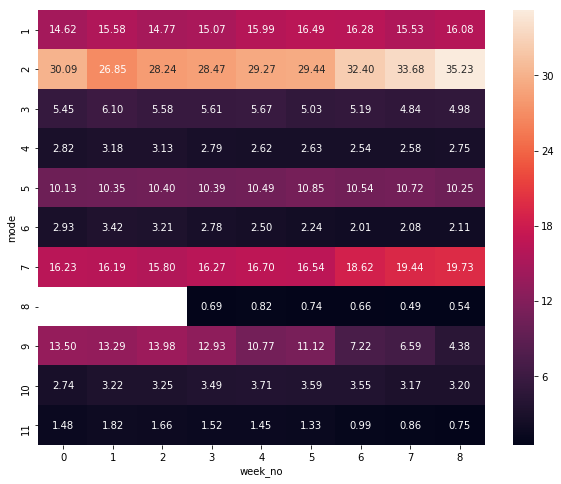

In [60]:
plt_ht(train)

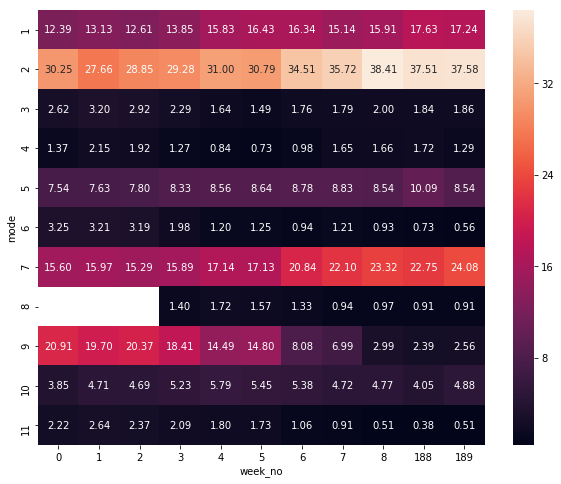

In [62]:
plt_ht(pd.concat([train_with_result, test_with_result], axis = 0, ignore_index = True))